Download data

In [59]:
!pip install fsspec
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=e15b4f853bf86925c1e011d22ace994c955e7a63ab51220bee31153ba4c911fc
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [2]:
import fsspec
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

destination = Path("data")
destination.mkdir(exist_ok=True, parents=True)
fs = fsspec.filesystem("github", org="lorenzovecchietti", repo="FinanceAI")
fs.get(fs.ls("data/"), destination.as_posix())

In [30]:
import os

def concatenate_text_files(folder_path, output_file):
    # List to hold the names of text files
    text_files = sorted([f for f in os.listdir(folder_path) if f.startswith("SPY")])

    with open(output_file, 'w', encoding='utf-8') as outfile:
        for filename in text_files:
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as infile:
                outfile.write(infile.read())  # Add newline for separation

# Example usage
folder_path = 'data'  # Replace with your folder path
output_file = 'data/1_min_SPY_2008-2021.csv'  # Output file name
concatenate_text_files(folder_path, output_file)

## Data Preparation

In [31]:
import pandas as pd
df=pd.read_csv(output_file, header=1, dtype={"Open":np.float32, "High":np.float32, "Low":np.float32, "Close":np.float32, "Volume":np.uint8,"Bars":np.uint8, "Average":np.float32}, names=["","DateTime Stamp", "Open", "High", "Low", "Close", "Volume","Bars", "Average"],usecols=[1,2,3,4,5,6,7,8], index_col=0, parse_dates=True, date_format='%Y%m%d  %H:%M:%S', sep=",")
print(df.head())

                          Open       High        Low      Close  Volume  Bars  \
DateTime Stamp                                                                  
2009-05-22 07:31:00  89.379997  89.529999  89.370003  89.500000     216   146   
2009-05-22 07:32:00  89.510002  89.540001  89.480003  89.489998      21   160   
2009-05-22 07:33:00  89.489998  89.489998  89.309998  89.339996     167   216   
2009-05-22 07:34:00  89.330002  89.459999  89.330002  89.389999       3    77   
2009-05-22 07:35:00  89.379997  89.410004  89.169998  89.180000      98    62   

                       Average  
DateTime Stamp                  
2009-05-22 07:31:00  89.468002  
2009-05-22 07:32:00  89.515999  
2009-05-22 07:33:00  89.386002  
2009-05-22 07:34:00  89.378998  
2009-05-22 07:35:00  89.273003  


# Clean Data

In [33]:
df.drop_duplicates(keep='first', inplace=False) # Remove duplicate rows
df.sort_index(inplace=True) # sort by date

## Check data

Check if there is any missing data

In [34]:
# Calculate the difference in minutes
diff_series = df.index.to_series().diff().dt.total_seconds() / 60

# Create a boolean mask for validity
validity_series = (diff_series == 1) | (df.index != df.index.to_series().shift(1))

# Convert to a Series with the same index
validity_series = pd.Series(validity_series.values, index=df.index)

# Print invalid entries
print(validity_series[~validity_series])

Series([], dtype: bool)


Print data description and plot

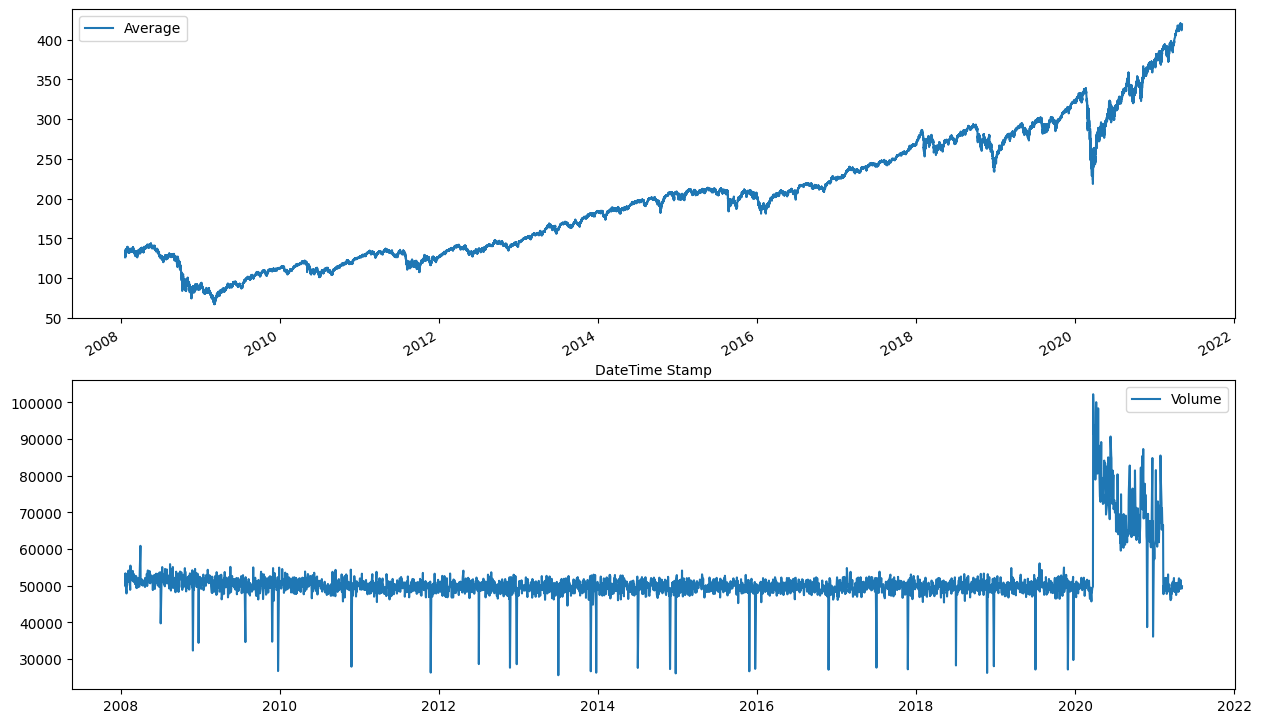

In [57]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
df.plot(y=['Average'], ax=axs[0])
df.groupby(by=df.index.date).sum().plot(y=['Volume'], ax=axs[1])
fig.show()

## Expanding data with trading indicators

In [60]:
import pandas_ta as ta

<ipython-input-103-091ceaa28932>:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.asfreq("1T")


,Open,High,Low,Close,Volume,Bars,Average,EMA_20,MACD,MACD_Hist,...,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,BBL_10_1.9,BBM_10_1.9,BBU_10_1.9,BBB_10_1.9,BBP_10_1.9
DateTime Stamp,,,,,,,,,,,,,,,,,,,,,
2008-01-22 07:30:00,126.449997,126.820000,126.000000,126.669998,11.0,189.0,126.282997,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-22 07:31:00,126.669998,127.169998,126.389999,127.120003,143.0,53.0,126.958000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-22 07:32:00,127.099998,127.129997,126.709999,126.779999,203.0,26.0,126.921997,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-22 07:33:00,126.760002,126.900002,126.529999,126.540001,81.0,70.0,126.675003,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-22 07:34:00,126.540001,127.180000,126.540001,126.779999,191.0,229.0,126.730003,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-06 13:55:00,418.559998,418.769989,418.480011,418.489990,113.0,232.0,418.660004,417.970438,0.368960,0.030683,...,417.206517,417.952000,418.697484,0.356732,0.860833,417.568297,418.207999,418.847701,0.305925,0.720409
2021-05-06 13:56:00,418.500000,418.730011,418.470001,418.640015,24.0,23.0,418.622009,418.034207,0.377182,0.031124,...,417.284063,418.020001,418.755939,0.352107,0.921240,417.695491,418.298999,418.902507,0.288553,0.782528
2021-05-06 13:57:00,418.640015,418.790009,418.630005,418.790009,0.0,52.0,418.743988,418.106188,0.391290,0.036186,...,417.325072,418.086502,418.847932,0.364245,0.961964,417.874173,418.407001,418.939828,0.254693,0.859411


In [108]:
df['EMA_20'] = ta.ema(df['Close'], length=20)
fast=12; slow=26; signal=9
macd = ta.macd(df['Close'], fast=fast, slow=slow, signal=signal)
df['MACD'] = macd[f"MACD_{fast}_{slow}_{signal}"]
df['MACD_Hist'] = macd[f"MACDh_{fast}_{slow}_{signal}"]
l=(20,10); std=(2.0,1.9)
for a,b in zip(l, std):
  df = pd.concat([df, ta.bbands(df['Close'], length=a, std=b)], axis=1)
df['RSI'] = ta.rsi(df['Close'], length=14)
df['VWAP'] = ta.vwap(df['High'], df['Low'], df['Close'], df['Volume'])
df['OBV'] = ta.obv(df['Close'], df['Volume'])
l=14
df["ADX"]=ta.adx(df['High'], df['Low'], df['Close'], length=l)[f"ADX_{l}"]
df['CMF'] = ta.cmf(df['High'], df['Low'], df['Close'], df['Volume'], length=20)
df['ROC'] = ta.roc(df['Close'], length=12)